In [160]:
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
#import data
from biom import load_table
from gneiss.util import match
#DEICODE
from DEICODE import untangle
#transforms 
from skbio.stats.composition import clr,ilr,centralize, ilr_inv
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
#regression
from gneiss.regression import ols
from gneiss.composition import ilr_transform
from gneiss.cluster import correlation_linkage
#else
%matplotlib inline
# make the notebook readable
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")

 Infant (case study)


 The colonization process of the infant gut microbiome has been called chaotic, but this view could reflect insufficient documentation of the factors affecting the microbiome. We performed a 2.5-year case study of the assembly of the human infant gut microbiome to relate life events to microbiome composition and function. Sixty fecal samples were collected from a healthy infant along with a diary of diet and health status.
 
 P.I.  Ruth Ley (Cornell University)
 [Data and Source](https://qiita.ucsd.edu/study/description/101#)

First we import the .biom OTU table and tab delimited mapping file (Qiime style) as pandas data frames. 

 Both of these datasets can be easily produced from your own 16S rRNA gene amplicon sequencing results using [Qiime2](https://qiime2.org)

In [220]:
# import observation data
in_biom='data/benchmarking/infant_time_series.biom' #import biom file
table = load_table(in_biom)
read_filter = lambda val, id_, md: sum(val) > 50
table.filter(read_filter, axis='sample')
table.filter(read_filter, axis='observation')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/infant_time_series_map.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
mappingdf.drop(['Color Description','Anonymized Name'],axis=1,inplace=True)
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf)

Next we will run supervised machine learning this will help us identify biologically relevant trends in the data quickly

In [221]:
# This command will do machine leanring on your otu table and mapping file. It ouputs your scores
# The main input is just the otu table and the mapping data. 
# complete will determine if you do completion (iteration is the number of iterations for the completion)
X_recovered=untangle.complete_matrix(otutabledf.as_matrix().copy(),rank=16,iteration=5)
X_recovered=pd.DataFrame(X_recovered,columns=otutabledf.columns,index=otutabledf.index)
infantscores,infant_low_rank_data=untangle.machine_learning(X_recovered.T,mappingdf,nmin=0,iteration=300,mean_count=40)

 Now we can visualize the output of the machine learning.

 The cross-validation scores give you a metric of how well each mapping category (i.e. metadata column) correlates to the taxonomic patterns in your data. Here we see that 4 metadata categories (solid-food, formula, breastmilk, and color description) correlate perfectly with the taxonomic trends.  

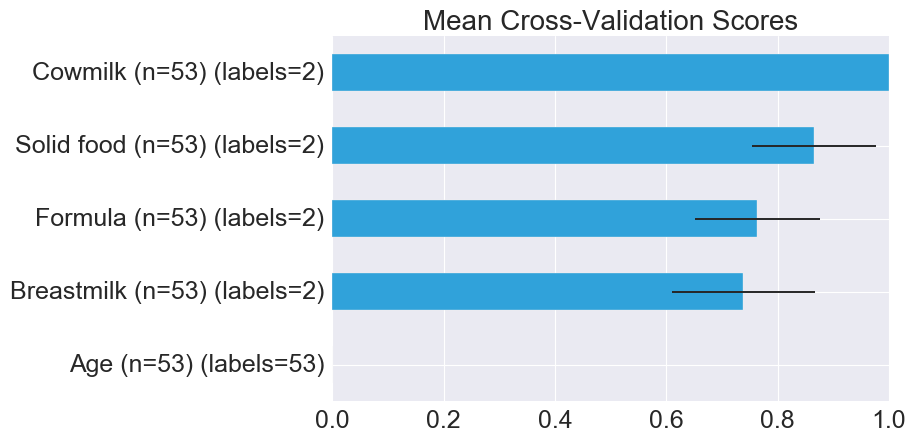

In [222]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
infantscores.sort_values(['Mean Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
infantscores['Mean Matrix Completion (RF)'].plot(kind='barh',xerr=np.array(infantscores['std Matrix Completion (RF)']),fontsize=18,xlim=(0,1),legend=False,ax=ax1)
ax1.set_ylabel('')
plt.title('Mean Cross-Validation Scores',fontsize=20)
plt.show()

    Now that we know cowsmilk is an important category we would like to find out what pattern of OTUs best explain this variation. Here we plot the taxonomic pattern that the machine learning algorithm found to be most predictive for the infant drinking cowsmilk (True) versus those time when he had not yet drank cowsmilk (False). The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

In [223]:
# get important features
n=10 # this will tell the command how many bacteria to plot
niche='Cowmilk' # this is a mapping file catagory you would like to plot
filter_names=['Unknown'] # this is a list of labels in the mapping you would like removed such as Unknown or Not available

X_recovered=untangle.complete_matrix(otutabledf.as_matrix().copy(),rank=8,iteration=40,minval=.1)
X_recovered=pd.DataFrame(X_recovered,columns=otutabledf.columns,index=otutabledf.index)

# complete will determine if you do completion (iteration is the number of iterations for the completion)
sfotus,sfmappingdf=match(X_recovered.T[X_recovered.sum()>100].T,mappingdf)
important_otus=untangle.features_ml(sfotus.T,sfmappingdf,niche)

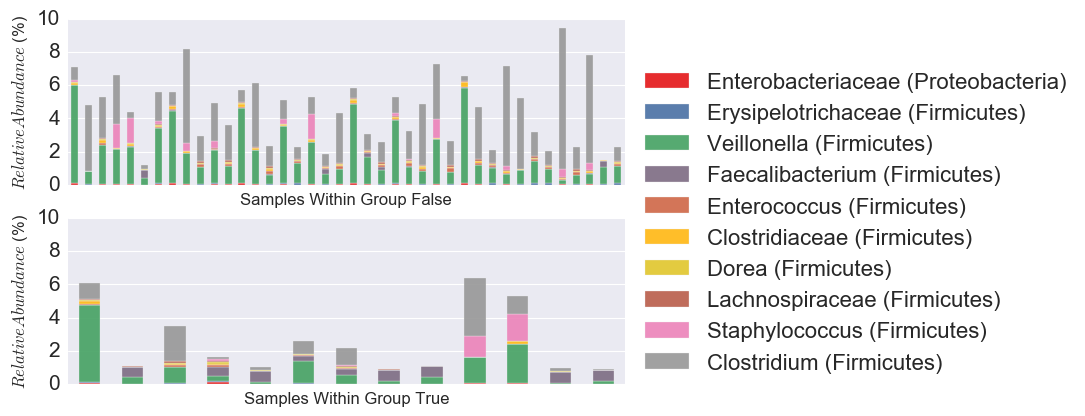

In [224]:
# plot
fig=untangle.feature_vis(sfotus,sfmappingdf.T,list(important_otus.index[:n]),niche,pd.DataFrame(taxonomy['taxonomy']))
plt.show()

 Here we find that the OTUs that best differentiate the samples between the infant pre and post scows milk are in the phylum Firmicutes. More specifically we see that the infant pre cows milk have a higher abundance of clostridiaceae compared to the infant after cowsmilk. 


From this we can conclude that the main OTU drivers between the cowsmilk and non-cowsmilk fed the infant are from the phyla Firmicutes. Importantly, we can also see that this separation is driven by missing or reduced OTUs in the formula fed infant.

Now we can view this pattern directly in the OTU table using biclustering, first we will write a simple plotting script allowing us to compare between before and after matrix completion

In [225]:
# we will use this as our simple plotting function
def plot_compare(org_otudata,comp_otu,mapping,catvis,titleadd=['Before Matrix Completion ','After Matrix Completion '],hmax=6,fig_fontsize=18):
    
    #transform
    clr_org_otudata=pd.DataFrame(clr(org_otudata.as_matrix().copy()+1),columns=org_otudata.columns,index=org_otudata.index)
    clr_comp_otu=pd.DataFrame(clr(comp_otu.as_matrix().copy()),columns=comp_otu.columns,index=comp_otu.index)
    biplots=[]
    for otudata,pcoaotu,title in zip([clr_org_otudata,clr_comp_otu],[org_otudata,comp_otu],titleadd):
    
        #biplot
        r=2
        biploto,datatmp=untangle.biplot(otudata.copy(),r)
        biplots.append([biploto,datatmp])
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(12, 5)) 

        if title!='':
            fig.suptitle('%s '%(title),fontsize=fig_fontsize+4)

        sns.heatmap(otudata,xticklabels=False, yticklabels=False,robust=True,cmap='RdBu_r',ax=ax1)
        ax1.set_title('OTU Table\n',fontsize=fig_fontsize)    
        ax1.set_ylabel('OTUs',fontsize=fig_fontsize-2)
        ax1.set_xlabel('Samples',fontsize=fig_fontsize-2)

        sns.heatmap(biploto,xticklabels=False, yticklabels=False,robust=True,cmap='RdBu_r',ax=ax2)
        ax2.set_title('Spectral Coclustering \n',fontsize=fig_fontsize)    
        ax2.set_ylabel('OTUs',fontsize=fig_fontsize-2)
        ax2.set_xlabel('Samples',fontsize=fig_fontsize-2)
        
        pcaplot=pcoa(DistanceMatrix(pdist(pcoaotu.as_matrix().T,'braycurtis'),list(pcoaotu.columns))).samples[['PC1','PC2','PC3']]
        pcaplot[catvis]=list(mapping.T[catvis])
        for ((key, grp)) in pcaplot.groupby(catvis):
            ax3.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
        ax3.set_title('PCoA (bray-curtis) \n',fontsize=fig_fontsize)
        ax3.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
        ax3.set_xlabel('$PC-2$',fontsize=fig_fontsize-2)    

        plt.tight_layout()
        fig.subplots_adjust(top=.78)

    return biplots

Now we will perform PCoA and biclustering for the OTU table before and after matrix completion 

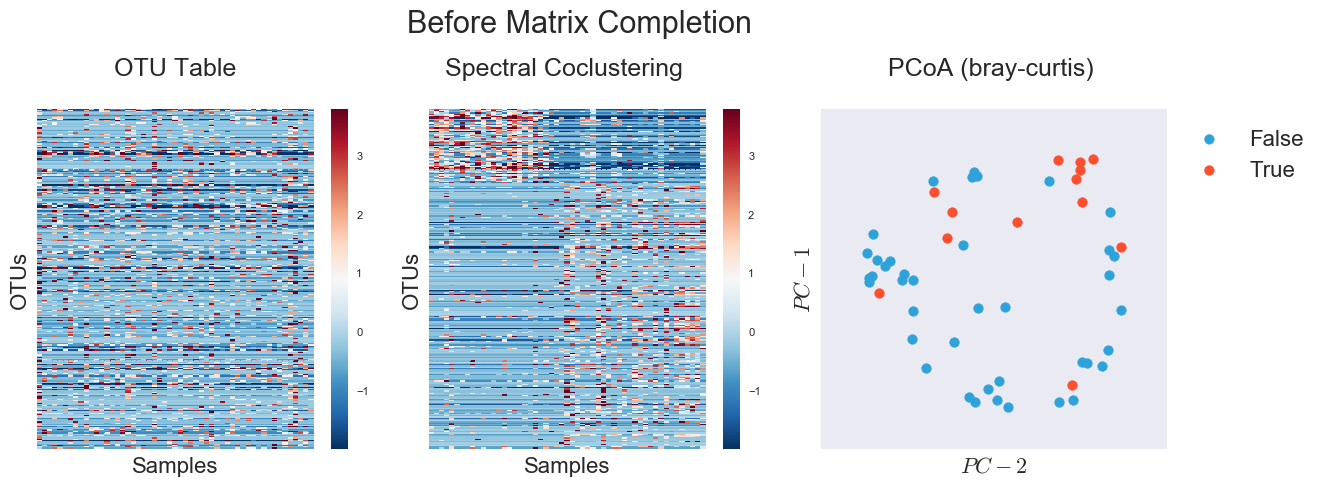

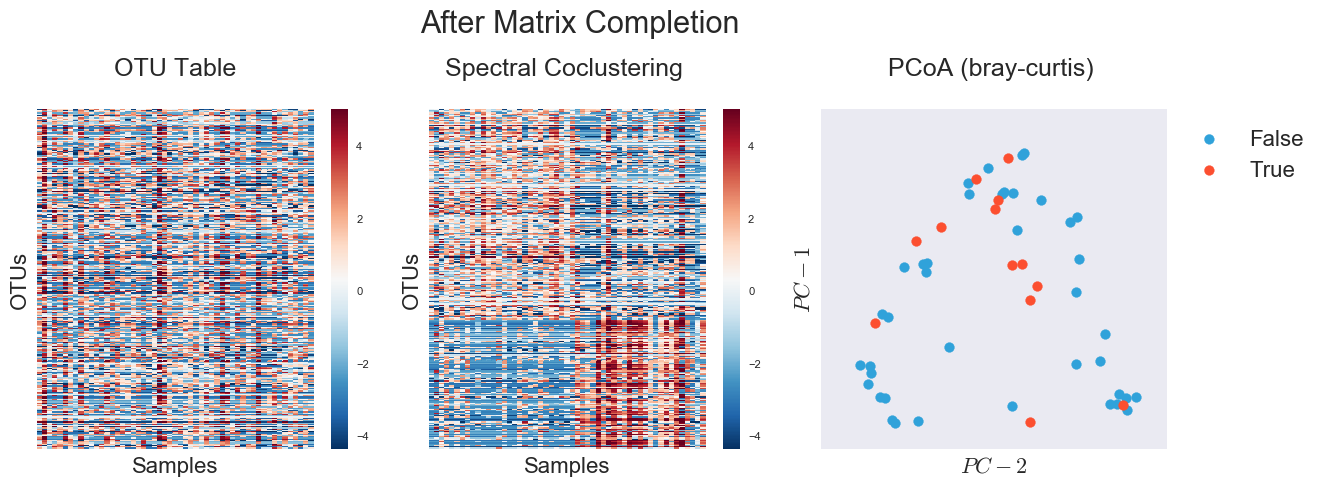

In [243]:
#complete the matrix
X_recovered=untangle.complete_matrix(otutabledf.as_matrix().copy(),rank=16,iteration=60,minval=.1)
X_recovered=pd.DataFrame(X_recovered,columns=otutabledf.columns,index=otutabledf.index)

#plot biplots comparison 
biplots=plot_compare(otutabledf.T,X_recovered.T,sfmappingdf.T,niche)
plt.show()

Finally, we can see that indeed we can sort the OTUs into the repective groups. This can be increibly powerful because you can start to view each cluster as community specfiic to different enviornments. 

## ols regression


We can run ols regression on the ilr transform to predict the microbiome on the important catagories we have identified. 

In [244]:
#run without completion
formula='Age+Breastmilk+Cowmilk+Formula'
tree = correlation_linkage(otutabledf+1)
balances_org = ilr_transform(otutabledf+1, tree=tree)
res_org = ols(table=balances_org, metadata=mappingdf,formula=formula)
res_org.fit()
cv_org = res_org.kfold(4)
#view results 
cv_org

,model_mse,Rsquared,pred_mse
fold_0,36.483569,0.338110,18.359882
fold_1,39.333721,0.284964,14.509299
fold_2,39.648253,0.305994,14.472149
fold_3,37.870586,0.311211,16.655501


In [252]:
#complete the matrix
X_recovered=untangle.complete_matrix(otutabledf.as_matrix().copy(),rank=2,iteration=20,minval=1)
X_recovered=pd.DataFrame(X_recovered,columns=otutabledf.columns,index=otutabledf.index)

#run regression 
formula='Age+Breastmilk+Cowmilk+Formula'
tree = correlation_linkage(X_recovered)
balances_completed = ilr_transform(X_recovered, tree=tree)
res_opt = ols(table=balances_completed, metadata=mappingdf,formula=formula)
res_opt.fit()
cv_opt = res_opt.kfold(4)
#view results 
cv_opt

,model_mse,Rsquared,pred_mse
fold_0,8.445026,0.364068,4.381597
fold_1,8.895120,0.406205,3.749677
fold_2,11.083908,0.350073,1.639564
fold_3,8.470971,0.480144,4.552354


Now lets write a small function to visualize this regression using PCoA

In [285]:
def regression_plot(origonal_table,completed_table,origonal_coeff,completed_coeff,first='PC1',second='PC2',fig_fontsize=18):
    
    origonal_table['Regression']=origonal_coeff
    completed_table['Regression']=completed_coeff
    
    pcoa_org=pcoa(DistanceMatrix(pdist(origonal_table.T.as_matrix(),'braycurtis'),list(origonal_table.columns))).samples[['PC1','PC2','PC3']]
    pcoa_opt=pcoa(DistanceMatrix(pdist(completed_table.T.as_matrix(),'braycurtis'),list(completed_table.columns))).samples[['PC1','PC2','PC3']]

    #plot
    fig, (ax1) = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
    
   
    for pcoa_out,key in zip([pcoa_org,pcoa_opt],['Psuedo Count','Completed']):
        c_=next(ax1._get_lines.prop_cycler)['color']
        ax1.scatter(pcoa_out.drop(['Regression'])[first], pcoa_out.drop(['Regression'])['PC2'], color=c_,label=key, s=50)
        ax1.plot(pcoa_out.drop(['Regression'])[first],pcoa_out.drop(['Regression'])[first]*pcoa_out.T['Regression'][first],label=key ,color=c_ )
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
    ax1.set_title('Regression Fit Comparison',fontsize=fig_fontsize,y=1.05)
    ax1.set_ylabel('$'+first+'$',fontsize=fig_fontsize-2)
    ax1.set_xlabel('$'+second+'$',fontsize=fig_fontsize-2)    
    return fig


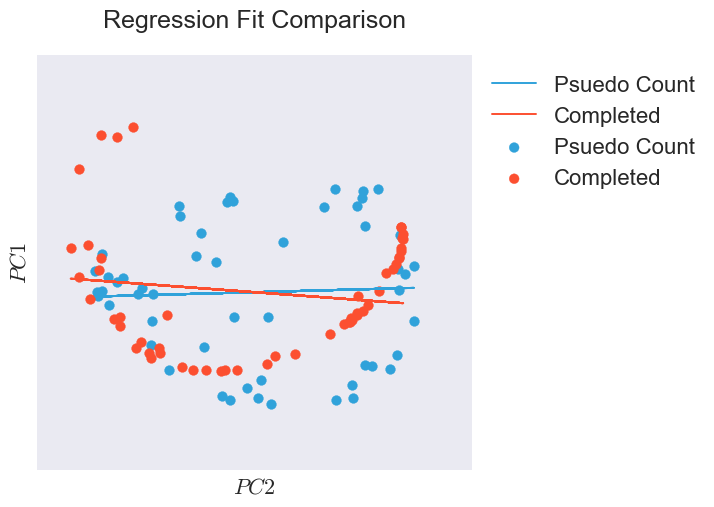

In [286]:
fig=regression_plot(otutabledf.T.copy(),X_recovered.T.copy(),
                ilr_inv(res_org.coefficients().T['Intercept'].values),
                ilr_inv(res_opt.coefficients().T['Intercept'].values))
plt.show()

We increased the $R^{2}$ by about .2 over every fold and decresed the mse by 3 or 4. 